### Подготовка к работе

In [1]:
# импорты
from nltk import word_tokenize
from rusenttokenize import ru_sent_tokenize
import random
import re
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
import pandas as pd
from string import punctuation
# from deeppavlov import build_model, configs 
# dpavlov_model = build_model("ru_syntagrus_joint_parsing", download=True)
# сохранили классы в переменные
morph = MorphAnalyzer()
stem = Mystem()
# библиотеки для частотного анализа
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
russian_stopwords = stopwords.words('russian')
from operator import itemgetter

import pickle

In [2]:
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~——«»–−'
custom_stop_words = ['это', 'который', 'свой']
russian_stopwords.extend(custom_stop_words)

In [3]:
# меняем формат вывода, чтобы можно было работать с тегами
dpavlov_model['main'].to_output_string = False
dpavlov_model['main'].output_format = 'dict'

### Функции

In [3]:
def pdf_normalize(text):
    '''обработка возможных сбоев после копирования из пдф формата'''
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'(?<=\w)\- |(?<=\w)­ ', '', text) # переносы слов
    text = re.sub(r' +', ' ', text) # лишние пробелы
    text = re.sub(r' \.', '.', text) # пробел перед точкой
    text = re.sub(r' ,', ',', text) # пробел перед запятой
    text = re.sub(r' \)', ')', text) # пробел перед скобкой
    text = re.sub('\(рис\. \d.\d(, \w)?\)', '', text) # указание номера рисунка
    text = re.sub(r'ё', 'е', text)
    text = re.sub(r'\.(?=[а-яА-Я])', '. ', text) # новое предложение без пробела
    text = re.sub(r'\xad', '', text)
    text = re.sub(r'\w—', ' —', text)
    text = re.sub(r'^ ', '', text)
    text = re.sub(r'\x0c', '', text)
    return text


In [4]:
def get_statistics(text):
    ''' возвращает общую статистику по тексту: 
    количество предложений, количество слов (кортежем)'''
    text_sents = ru_sent_tokenize(text)
    text_words = [word.strip(punctuation) for word in word_tokenize(text)]
    text_words = [word for word in text_words if word]
    return text_sents, text_words    

In [5]:
def preprocessing(text):
    tokens = [word.strip(punctuation) for word in word_tokenize(text)]
    clean_tokens = [word.lower() for word in tokens if word]
    clean_tokens = [word for word in clean_tokens if len(word) > 2]
    clean_lemmas = [morph.parse(word)[0].normal_form for 
                    word in clean_tokens]
    clean_lemmas = [word for word in clean_lemmas if 
                    word not in russian_stopwords]
    return clean_lemmas

In [6]:
def get_topn_words(vector, n):
    '''вовращает n самых частотных слов по данному вектору'''
    tfidf_scores = [(feature_names[col], vector[0, col]) for 
                    col in vector.nonzero()[1]]
    freq_list = [pair[0] for pair in sorted(tfidf_scores, key=itemgetter(1), 
                                                       reverse=True)]
    return freq_list[:n]

In [8]:
def exercise_dict(parsed_data, pos, value, file_name):
    '''1ый аргумент - список, содержащий словари, где слово - это ключ, а значение - 
    грамматические тэги;
        2ой аргумент - часть речи; 3ий - дополнительные тэги;
        4ый - имя файла, в который будет записан словарь
    '''
    pos_ex = {}
    for index, sent in parsed_data:
        #  предложение из текста
        exercise = sents[index] # оригинальное предложение по индексу распарсенного
        #  пустая переменная для правильного ответа
        correct_answer = ''
        #  счетчик наличия части речи
        q = 0
        for word in sent: # проверка каждого слова в предложении
            if word['upos'] == pos and value in word['feats']: # ищем нужную часть речи
                q += 1
                target_word = f'({ word["lemma"]})'
                exercise = exercise.replace(word['word'], target_word) # нужное слово меняется на формат '(lemma)'
                correct_answer += word['word'] # записываем правильный ответ (слово из предложения)
        if q > 0: # если встретилась часть речи добавляем пары ключ(предложение из текста) - предложение в формате упражнения и правильный ответ
            pos_ex[sents[index]] = [exercise, correct_answer]
    return pos_ex

### Подготовка корпуса

In [9]:
# открываем табличку с текстами и мета-информцией
df = pd.read_csv('Corpus.csv')
pd.set_option('max_colwidth', None)
#  создаем строковую переменную для текстов
corpus = list(df['текст'])
str_corpus = ' '.join(text for text in corpus)

# чистим корпус
str_corpus = pdf_normalize(str_corpus)
# создаем текстовый файл только с текстами
# with open('raw_texts.txt', 'w', encoding='utf-8') as f:
#     f.write(str_corpus)

### Статистика по текстам

In [10]:
# переменные с текстами одной тематики
materved = ' '.join(list(df.loc[df['тематика'] == 'материаловедение', 'текст']))
electr = ' '.join(list(df.loc[df['тематика'] == 'теория электрических цепей',
                              'текст']))
general = ' '.join(list(df.loc[df['тематика'] == 'общая', 'текст']))
materved = pdf_normalize(materved)
electr = pdf_normalize(electr)
general = pdf_normalize(general)

# статистика по каждой тематике
materved_sents, materved_words = get_statistics(materved)
electr_sents, electr_words = get_statistics(electr)
general_sents, general_words = get_statistics(general)

# частотные списки для каждой тематики
theme_list = [materved, electr, general]
tf_idf_vec = TfidfVectorizer(tokenizer=preprocessing)
vectors = tf_idf_vec.fit_transform(theme_list)
feature_names = tf_idf_vec.get_feature_names()
materved_voc = ', '.join(get_topn_words(vectors[0], 50))
electr_voc = ', '.join(get_topn_words(vectors[1], 50))
general_voc = ', '.join(get_topn_words(vectors[2], 50))

In [11]:
data = [[len(materved_sents), len(materved_words), materved_voc],
        [len(electr_sents), len(electr_words), electr_voc],
        [len(general_sents), len(general_words), general_voc]]
df_stat = pd.DataFrame(data, 
                       index = ['материаловедение', 'теория электрических цепей', 
                                'общая'], 
                       columns = ['Кол-во предложений', 'Кол-во словоупотреблений', 
                                  'Частотный список' ])
df_stat.insert(2, 'Кол-во текстов', df['тематика'].value_counts())
df_stat.loc['Total'] = df_stat.sum(numeric_only=True, axis=0)
df_stat

,Кол-во предложений,Кол-во словоупотреблений,Кол-во текстов,Частотный список
материаловедение,444.0,6961.0,15.0,"материал, температура, вещество, металл, кристалл, состояние, свойство, кристаллический, решётка, атом, твёрдый, дислокация, кристаллизация, строение, изделие, жидкость, жидкий, давление, форма, плотность, сплав, поверхность, способность, мочь, различный, размер, механический, структура, материаловедение, энергия, переход, аморфный, внешний, определённый, агрегатный, условие, воздействие, система, дефект, находиться, газ, молекула, керамика, зерно, изменение, иметь, являться, объём, коррозия, процесс"
теория электрических цепей,357.0,5404.0,22.0,"ток, напряжение, комплексный, ёмкость, сопротивление, электрический, индуктивность, источник, цепь, рисунок, элемент, мощность, значение, амплитуда, энергия, ветвь, функция, гармонический, мгновенный, время, показать, называться, соединение, равный, схема, узел, вывод, положительный, обозначение, контур, активный, направление, выражение, фаза, уравнение, условный, заряд, закон, вид, последовательный, резистор, величина, реальный, свойство, сумма, идеализированный, равно, участок, поле, мнимый"
общая,1465.0,15991.0,51.0,"год, русский, человек, москва, город, любить, россия, день, дом, сказать, стать, жизнь, друг, художник, жить, известный, время, мочь, писатель, университет, институт, первый, весь, толстой, знать, всё, самый, земля, хороший, учёный, картина, посмотреть, война, великий, царский, ответить, академия, работать, век, очень, музей, решить, центр, большой, час, писать, деньга, столица, находиться, санкт-петербург"
Total,2266.0,28356.0,88.0,NaN


array([[<AxesSubplot:ylabel='Кол-во предложений'>,
        <AxesSubplot:ylabel='Кол-во словоупотреблений'>,
        <AxesSubplot:ylabel='Кол-во текстов'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

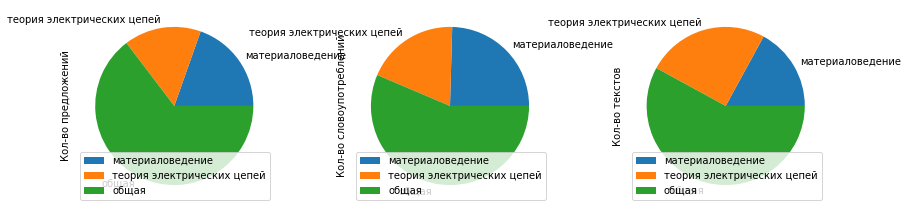

In [13]:
pieplot_cols = ['Кол-во предложений', 'Кол-во словоупотреблений', 'Кол-во текстов']
df_stat[pieplot_cols].iloc[:3].plot(kind='pie', subplots=True, layout=(2,3), figsize=(14,8))

### Извлечение предложений с нужными частями речи

In [9]:
with open('raw_texts.txt', 'r', encoding='utf-8') as f:
    texts = f.read()
sents = ru_sent_tokenize(texts)

# проверка на неверно разделенные предложения
for sent in enumerate(sents):
    if re.search(r'\w\. \w', sent[1]):
        print(sent)
# исправления для одного предложения, разделенного на несколько
sents[1192] += sents[1193]

sents[1214] += sents[1215]

sents[1234] = sents[1234] + sents[1235] + sents[1236]

sents[1243] += sents[1244]
# исправления для нескольких предложений, склеенных в одно
pattern = re.compile('(?<=\.) (?=[А-Я])') 
for sent in [81, 137, 162, 185, 498, 521, 526, 529, 540, 629]:
    sents.extend(pattern.split(sents[sent]))
# удаляем исправленные предложения
sents_to_remove = []
for sent in [81, 137, 162, 185, 498, 521, 526, 529, 540, 629, 1193, 1215, 
             1235, 1236, 1244]:
    sents_to_remove.append(sents[sent])
for elem in sents_to_remove:
    sents.remove(elem)

(13, 'Большие увеличения позволяют определять в этом случае размеры, форму, взаимное расположение и количество кристаллов различных фаз, т. е. микроструктуру материала.')
(22, 'Композиты представляют собой комбинацию из двух (или большего числа) отдельных материалов, относящихся к различным классам веществ, перечисленным выше, т. е. металлов, керамики и полимеров.')
(28, 'Материалы этого типа не должны выделять токсичных веществ и должны быть совместимыми с тканями человека (т. е. не должны вызывать реакции отторжения).')
(81, 'Стеклообразное состояние вещества – агрегатное состояние вещества с аморфным строением, формирующееся при затвердевании переохлажденного расплава и обладающее в результате постепенного увеличения вязкости механическими свойствами твердых тел. Переход из стеклообразного состояния в расплав и из расплава в стеклообразное состояние характеризуется температурным интервалом, а его обратимость является особенностью, которая отличает стеклообразное состояние от других 

Примерно 15 ошибок на 2276 предложений - получается, менее 1%.

In [10]:
# парсить пришлось отдельными частями, потому что если полностью, то почему-то зависало
parsed_sents = dpavlov_model(sents[:500])
parsed_sents_part2 = dpavlov_model(sents[500:1000])
parsed_sents_part3 = dpavlov_model(sents[1000:1500])
parsed_sents_part4 = dpavlov_model(sents[1500:2000])
parsed_sents_part5 = dpavlov_model(sents[2000:])
# объединяем все вместе
sents_list = [parsed_sents_part2, parsed_sents_part3, parsed_sents_part4, 
              parsed_sents_part5]
for part in sents_list:
    parsed_sents.extend(part)

len(parsed_sents)

2276

In [11]:
# словарь для упражнений
parsed_sents_en = list(enumerate(parsed_sents))
exercise_dict(parsed_sents_en, 'VERB', 'Case', 'prtf.pickle')
exercise_dict(parsed_sents_en, 'VERB', 'Short', 'prtf_short.pickle')
exercise_dict(parsed_sents_en, 'ADJ', 'Cmp', 'adj_cmp.pickle')
exercise_dict(parsed_sents_en, 'ADJ', 'Sup', 'adj_sup.pickle')

In [53]:
suspicious_sents = {}
okay_sents = {}
for sent in parsed_sents_en:
    exercise = sents[sent[0]]
    correct_answer = ''
    q = 0
    neg = 0
    for word in sent[1]:
        if word['upos'] == 'ADJ' and 'Short' not in word['feats']:
            if morph.parse(word['word'])[0].tag.POS == 'ADJF':
                q += 1
                target_word = f'({word['lemma'])'
                exercise = exercise.replace(word['word'], target_word)
                correct_answer += word['word']
                
            else:
                neg += 1
                target_word = f'(word['lemma'])'
                exercise = exercise.replace(word['word'], target_word)
                correct_answer += word['word']
                
                
    if q > 0 and neg == 0:
        okay_sents[sents[sent[0]]] = [exercise, correct_answer]
    elif neg > 0:
        suspicious_sents[sents[sent[0]]] = [exercise, correct_answer]
        
with open('ADJ_full.pickle', 'wb') as f:
    pickle.dump(okay_sents, f)

In [57]:
suspicious_sents2 = {}
okay_sents2 = {}
for sent in parsed_sents_en:
    exercise = sents[sent[0]]
    correct_answer = ''
    q = 0
    neg = 0
    for word in sent[1]:
        if word['upos'] == 'ADJ' and 'Short' in word['feats']:
            if morph.parse(word['word'])[0].tag.POS == 'ADJS':
                q += 1
                target_word = f'({word['lemma']})'
                exercise = exercise.replace(word['word'], target_word)
                correct_answer += word['word']
                
            else:
                neg += 1
                target_word = f'({word['lemma'])'
                exercise = exercise.replace(word['word'], target_word)
                correct_answer += word['word']
                
                
    if q > 0 and neg == 0:
        okay_sents2[sents[sent[0]]] = [exercise, correct_answer]
    elif neg > 0:
        suspicious_sents2[sents[sent[0]]] = [exercise, correct_answer]
        
with open('ADJ_short.pickle', 'wb') as f:
    pickle.dump(okay_sents2, f)